# How to Optimally Bias Random Walk with Restart

a short tutorial about OBRWR.

---

For OBRWR run on real data, have a look at the github repository.

In [1]:
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt 
import path_extract as pe
%matplotlib widget

import ipywidgets as wd
from ipywidgets import interactive

from obrwr import obrwr_new as ob

### Defining the network

Here we will use an Erdos-Renyi graph

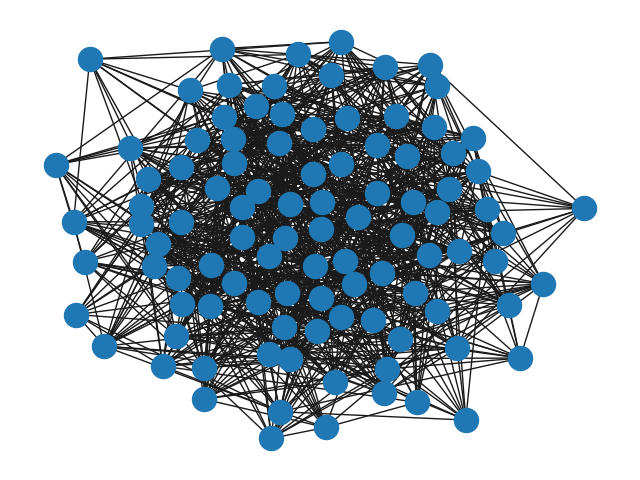

In [2]:
experiment = "Tutorial"
N = 100
G = nx.fast_gnp_random_graph(N,p=1/5)
nx.draw(G)

### Defining the activated protein
Since everything is linear we use a scaling factor to minimize rounding errors.

We set node O as only activated network.

In [3]:
factor = 1e4
myGraph = ob.MyGraph(G)
myGraph.set_sources([0],factor)

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


[0]

### Lets generate a phosphorylation profile using RWR
To generate a profile we generate a random stochastic matrix M.

And compute the associated random walk with restart limit v.

In [4]:
A = nx.adjacency_matrix(G).todense()
degrees = [d for (el,d) in G.degree]
D = np.diag(degrees)
Wrw = A @ np.linalg.inv(D)
W = np.zeros((N,N))

for i in range(N):
    d = degrees[i]
    weights = np.random.random(d)
    weights = weights/np.sum(weights)
    for j,neigh in enumerate(list(nx.neighbors(G,i))):
        W[neigh,i] = weights[j]
beta=0.7
eps = 0.3
M = (1-eps)*Wrw +eps*W

s = np.zeros(N)
s[0]=factor

v =beta*np.linalg.inv(np.eye(N) - (1-beta)*M)@s 
v = np.ravel(v)

We've generated a profile v using RWR, let's sample only n proteins and set them as target for OBRWR

In [5]:
n = 10
phos_prot = np.random.choice(range(N),n)
d = {el:v[el] for el in phos_prot}
myGraph.set_targets(d,OF=True)

93 7.074287791955267
26 94.86172691087327
49 9.080713404309309
63 65.26654069864827
46 3.8297343966460886
72 3.3834308783556057
58 70.06813887092765
47 8.884421880683847
15 5.8481924879881975
80 72.43439155870996


### Plotting the landscape of objective optimum for varying $\epsilon$

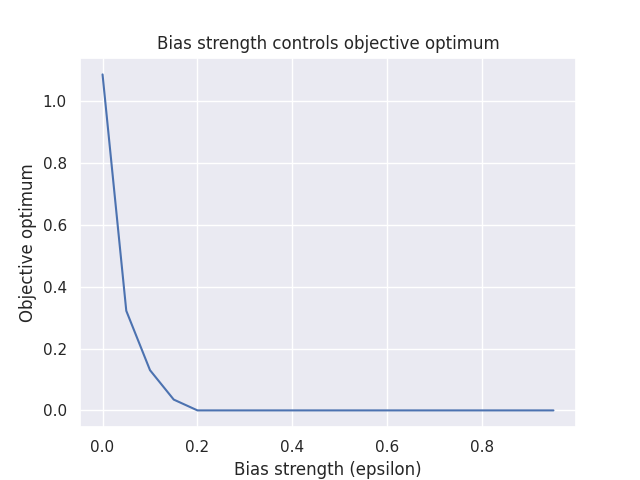

In [6]:
myGraph.plot_objective_eps(beta,OF=False,objective=ob.OBJ_VAR_FROM_VAL)

### Retrieving optimal $\epsilon$

In [7]:
eps_crit,pi = myGraph.find_eps_critic(beta,1e-2,objective=ob.OBJ_VAR_FROM_VAL,OF=False)
eps_crit

0.174609375

### Running obrwr with optimal $\epsilon$
Here the myGraph object only knows about source and target values.

In [8]:
_ = myGraph.optimize_biased_walk_normalized(eps_crit,beta,objective=ob.OBJ_VAR_FROM_VAL,name=experiment)

### Retrieving $W_\text{opt}$

In [9]:
Wopt = myGraph.W_hat
predv = beta*np.linalg.inv(np.eye(N) - (1-beta)*Wopt)@s
predv = np.ravel(predv)

### Checking that the true values and predicted values match

In [10]:
for node,true_val in d.items():
    print(f"Node {node}:")
    print(f"True value :{true_val:.2f}")
    print(f"Pred value :{predv[node]:.2f}")

Node 93:
True value :7.07
Pred value :7.07
Node 26:
True value :94.86
Pred value :94.86
Node 49:
True value :9.08
Pred value :9.08
Node 63:
True value :65.27
Pred value :65.42
Node 46:
True value :3.83
Pred value :3.83
Node 72:
True value :3.38
Pred value :3.38
Node 58:
True value :70.07
Pred value :70.07
Node 47:
True value :8.88
Pred value :8.88
Node 15:
True value :5.85
Pred value :5.85
Node 80:
True value :72.43
Pred value :72.43


### It does not match on all nodes in the network

Min relative : 0.24428070607093352
Max relative : 1.6643004479914658


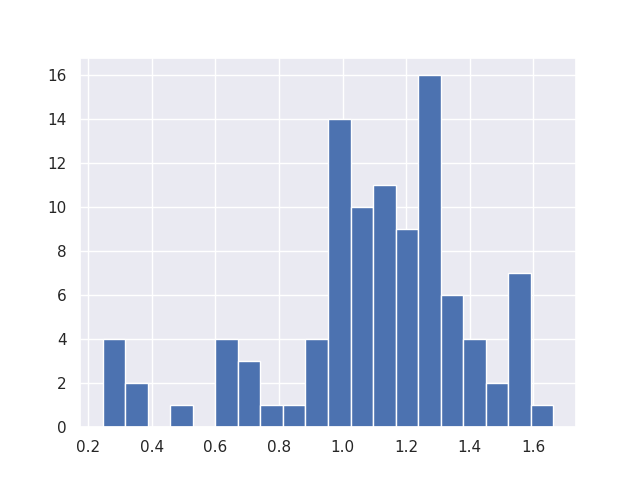

In [11]:
plt.subplots()
relative = [v[i]/predv[i] for i in range(N)]
print(f'Min relative : {np.min(relative)}')
print(f'Max relative : {np.max(relative)}')
plt.hist(relative,bins=20)
plt.show()

But it's not too far off.

### Going back to Networkx 
The myGraph.subGdirected_with_annot object is a networkx which gets annotated when calling
the add_meta_after_optim method.

So we can save it and open it in our favorite network tool (Cytoscape)

In [13]:
myGraph.add_meta_after_optim(eps_crit,beta,experiment)
Gannot = myGraph.subGdirected_with_annot
nx.write_gml(Gannot,"tutorial.gml")

### Retrieve targets from myGraph object

In [14]:
targets_attr = nx.get_node_attributes(Gannot,'Targets')
original_targets = [n for n in Gannot.nodes() if targets_attr[n]]

### Retrieving the most contributing paths

In [15]:
pathstotarget = pe.enumerate_path_heap(Gannot,original_targets,experiment,source=0,r=1e-1,mode='percent')

In [16]:
pathstotarget

{15: [[[0, 98, 15], [0, 41, 15], [0, 58, 15], [0, 35, 15]],
  4.2686833155900095],
 26: [[[0, 26], [0, 63, 26]], 86.1050825899617],
 46: [[[0, 97, 46], [0, 95, 46], [0, 35, 46], [0, 99, 48, 46]],
  2.632728491356864],
 47: [[[0, 63, 47], [0, 56, 47], [0, 97, 47], [0, 16, 47]], 4.259504816632198],
 49: [[[0, 7, 49], [0, 18, 49]], 3.63271732165298],
 58: [[[0, 58], [0, 7, 58]], 64.06316111211149],
 63: [[[0, 63], [0, 26, 63]], 60.74608580265195],
 72: [[[0, 87, 72], [0, 12, 72], [0, 7, 30, 72]], 1.493277120984107],
 80: [[[0, 80], [0, 80, 80]], 66.55969818262243],
 93: [[[0, 2, 93], [0, 99, 93], [0, 87, 93]], 3.773092592409505]}

### We will not run the random sampling here please refer to github where there are plenty examples